In [1]:
# read library

import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages')
# sys.path.insert(0, '/usr/local/lib/python3.7/site-packages')
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# import pkg_resources
# pkg_resources.require("numpy==1.16.0")#15.4")
import numpy as np


# Feature Engineering

01. address ==> extract 'part' of Berlin
02. price ==> remove characters (€ , .)
03. livingSpace ==> remove (m2)
04. rooms ==> remove (Zi, redundant number)
05. tag1, tag2 ==> one-hot encoding

In [4]:
# scrapped data
df = pd.read_csv('immo_berlin_1_100_t2.csv')

## Price

In [5]:
df['price'] = df['price'].str.replace(' €', '').replace(',', '.').str.split().str[0]
df_price = df[df['price'].str.find(',')<0]
df_price['price'] = df_price['price'].str.replace('.', '').astype(float)

/Users/soyoung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df_price = df_price[df_price['price']>100000]

In [8]:
df = df_price.copy()

## Space

In [9]:
df['livingSpace'] = df['livingSpace'].map(lambda x: x.replace(' m²', '').replace(',', '.').split()).str[0].astype(float)


## room

In [10]:
import re
df['rooms'] = df['rooms'].str.split().str[0]
df['rooms'] = df['rooms'].map(lambda x: x.replace(',', '.'))
df['rooms'] = df['rooms'].map(lambda x: re.sub(r'[^0-9^\-\.]+', 'NaN', x).replace(',', ''))

## agency

In [11]:
df['noAgency'] = df['tag1'].str.contains('Provisionsfrei*').astype(float) +\
df['tag2'].str.contains('Provisionsfrei*').astype(float)

## balcon

In [12]:
df['balcon'] = df['tag1'].str.contains('Balkon/Terrasse').astype(float) +\
df['tag2'].str.contains('Balkon/Terrasse').astype(float)

## kitchen

In [13]:
df['kitchen'] = df['tag1'].str.contains('Einbauküche').astype(float) +\
df['tag2'].str.contains('Einbauküche').astype(float)

In [14]:
df['elevator'] = df['tag1'].str.contains('Aufzug').astype(float) +\
df['tag2'].str.contains('Aufzug').astype(float)

In [15]:
df['base'] = df['tag1'].str.contains('Keller').astype(float) +\
df['tag2'].str.contains('Keller').astype(float)

In [16]:
# remove livingSpace == 0
df = df[df['livingSpace']!=0]

In [17]:
## Drop columns

In [18]:
cols2drop = ['web-scraper-order', 'web-scraper-start-url', 'title', 'tag1', 'tag2','linkRef']
df_drop = df.drop(cols2drop, axis=1)

# Feature engineer

In [19]:
df['price/m2'] = df['price']/df['livingSpace']

In [20]:
# exclude outlier
df = df[df['price/m2']<50000] 

# EDA

## histogram

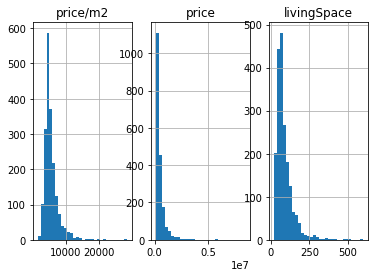

In [21]:
plt.subplot(1,3,1); plt.title('price/m2')
df['price/m2'].hist(bins=30)
plt.subplot(1,3,2); plt.title('price')
df['price'].hist(bins=30)
plt.subplot(1,3,3); plt.title('livingSpace')
df['livingSpace'].hist(bins=30)
plt.show()

In [23]:
berlin_part = ['Mitte', 'Prenzlauer Berg', 'Neukölln','Steglitz','Schöneberg','Kreuzberg','Friedrichshain',\
    'Charlottenburg','Moabit','Pankow','Gesundbrunnen','Wedding','Reinickendorf','Weißensee','Tiergarten',\
    'Wannsee','Grunewald','Tempelhof', 'Tegel','Spandau','Mariendorf','Alt-Treptow','Britz',\
    'Niederschönhausen','Johannisthal','Wilmersdorf','Nikolassee','Buchholz','Friedenau','Biesdorf',\
    'Lichterfelde','Lichtenrade','Niederschöneweide','Neu-Hohenschönhausen','Alt-Hohenschönhausen',\
    'Westend','Buckow','Alt-Treptow','Hohenschönhausen','Oberschöneweide','Plänterwald','Wittenau',\
    'Schmargendorf','Adlershof','Zehlendorf', 'Kladow','Marzahn','Köpenick','Karlshorst','Dahlem',\
    'Rummelsburg','Waidmannslust','Bohnsdorf','Altglienicke','Schmargendorf','Konradshöhe','Borsigwalde',\
    'Staaken','Friedrichsfelde','Wilhelmstadt', 'Hakenfelde','Buch','Halensee','Kaulsdorf','Lankwitz',\
    'Marienfelde','Müggelheim','Hermsdorf','Wilhelmsruh','Grünau','Friedrichshagen','Karow','Frohnau',\
    'Hansaviertel','Baumschulenweg','Gatow','Hansaviertel','Heiligensee','Mahlsdorf','Märkisches Viertel',\
    'Lübars','Siemensstadt','Falkenhagener Feld','Lichtenberg','Gropiusstadt'\
              ]   

In [24]:
import numpy as np
df['part'] = np.nan
for part in berlin_part:
    if part in (['Mitte', 'Neukölln', 'Pankow', 'Reinickendorf','Spandau']):
        add_part = '(Ortsteil)'
        df.loc[(df['address'].str.contains(part)) & (df['address'].str.contains(add_part)),'part'] = part
    else:
        add_part = ''
        df.loc[(df['address'].str.contains(part + ', Berlin')), 'part'] = part

/Users/soyoung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [26]:
top50_part = df['part'].value_counts()[:70].keys()

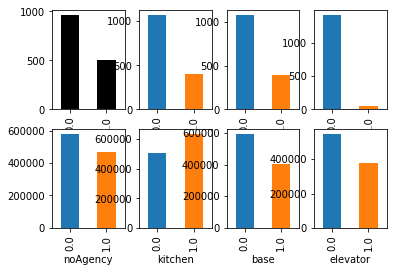

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4)
df['noAgency'].value_counts().plot.bar(ax=axes[0,0],cmap='gray')
df['kitchen'].value_counts().plot.bar(ax=axes[0,1])
df['base'].value_counts().plot.bar(ax=axes[0,2])
df['elevator'].value_counts().plot.bar(ax=axes[0,3])
df.groupby('noAgency')['price'].mean().plot.bar(ax=axes[1,0])
df.groupby('kitchen')['price'].mean().plot.bar(ax=axes[1,1])
df.groupby('base')['price'].mean().plot.bar(ax=axes[1,2])
df.groupby('elevator')['price'].mean().plot.bar(ax=axes[1,3])

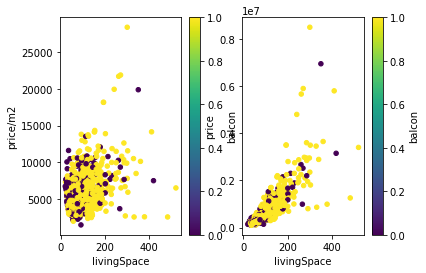

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df.plot(kind= 'scatter', x='livingSpace', y='price/m2',ax=axes[0], c='balcon',cmap='viridis')
df.plot(kind= 'scatter', x='livingSpace', y='price',ax=axes[1], c='balcon',cmap='viridis')
plt.show()

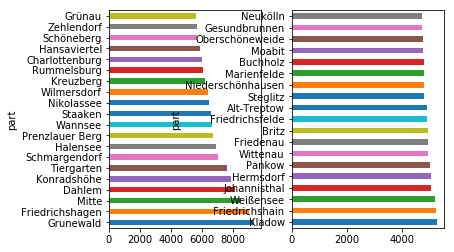

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df.groupby('part')['price/m2'].mean().sort_values(ascending=False)[:20]\
.plot.barh(fontsize=10, ax=axes[0])#figsize=(5,5), 
df.groupby('part')['price/m2'].mean().sort_values(ascending=False)[21:40]\
.plot.barh(fontsize=10, ax=axes[1])#figsize=(5,5), 
#[df['part']].isin(top50_part)

/Users/soyoung/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


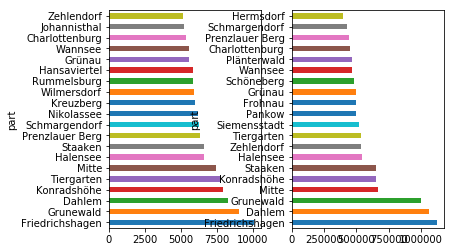

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df.groupby('part').aggregate(lambda series: np.median(series.values)).\
sort_values(by='price/m2',ascending=False)['price/m2'][:20].plot.barh(ax=axes[0])
df.groupby('part').aggregate(lambda series: np.median(series.values)).\
sort_values(by='price',ascending=False)['price'][:20].plot.barh(ax=axes[1])
#np.floor(len(series.values))])

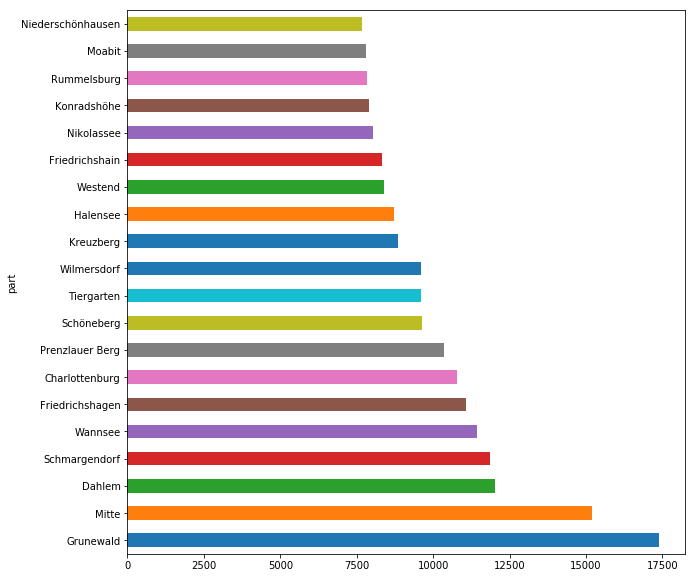

In [78]:
df.groupby('part')['price/m2'].aggregate(lambda series: np.median(series.quantile(0.95)))\
.sort_values(ascending=False)[:20].plot.barh(figsize=(10,10))

In [ ]:
## to throw away

In [ ]:
# from mpl_toolkits.basemap import Basemap

In [ ]:
# import pkg_resources
# installed_packages = pkg_resources.working_set
# installed_packages_list = sorted(["%s==%s" % (i.key, i.version)
#    for i in installed_packages])
# print(installed_packages_list)
# help("modules")

In [ ]:
tmp = df['price'].str.replace(' €', '')
tmp2 = tmp.replace(',', '')
tmp3 = tmp2.replace('.', '')

In [ ]:
(tmp3.str.split()).str[0].head(5)

In [ ]:
longInd = df['price'].str.find(',')==7
df.loc[longInd, 'price'] = df.loc[longInd,'price'].str[:7].map(lambda x: x.replace('.', '')).astype(float)

In [ ]:
superlongInd = df['price'].str.find(',')==9
df.loc[superlongInd, 'price'] = df.loc[superlongInd, 'price'].str[:9].map(lambda x: x.replace('.', '')).astype(float)

In [ ]:
shortInd = df['price'].str.find('.')==3
df.loc[shortInd, 'price'] = df.loc[shortInd, 'price'].map(lambda x: x.replace('.', '')).astype(float)#*10

In [ ]:
exceptInd = df['price'].str.find(',')==1
df.loc[exceptInd, 'price'] = df.loc[exceptInd, 'price'].map(lambda x: x.replace(',', '')).astype(float)*1000

In [ ]:
verylongInd = df['price'].str.find('.')==1
df.loc[verylongInd, 'price'] = df.loc[verylongInd, 'price'].map(lambda x: x.replace('.', '')).astype(float)

In [ ]:
# df['price'] = df['price'].map(lambda x: x.replace(' €', '').replace(',', '').split()).str[0].astype(float)#.replace('.', '')
# df.loc[df['price'].str.find(',')>0]['price'].astype(float)#.apply(lambda x: round(x, decimals))
# df['price'].map(lambda x: x.replace(' €', ''))
#df['rooms'].map(lambda x: x.str.replace(r"[a-zA-Z]",'')).astype(float)#.astype(str).str[0].astype(float)#map(lambda x: x.lstrip)